## Importing libraries

In [1]:
## Importing libraries
import sys, os
import numpy as np
import pandas as pd

import pickle as pkl
import scipy.stats as stats

import torch
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, FashionMNIST


import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 400

import seaborn as sns

from auxiliary_functions import *

In [2]:
ROOT_PATH = '/'.join(os.getcwd().split('/')[:-1])
methods_VanHat_dir = f'{ROOT_PATH}/Methods/VanHateren_Gamma/'
methods_MNIST_dir = f'{ROOT_PATH}/Methods/MNIST_domains/'

In [3]:
sys.path.append(methods_VanHat_dir)
from methods import CsikorDataset, CsikorShuffDataset, Laplace_FC_VAE, Gamma_free_Laplace_FC_VAE, replace_point_by_underscore
sys.path.append(methods_MNIST_dir)
import medmnist
from medmnist import INFO, Evaluator

## Set whether to use manuscript results or own trained models.
### If evaluating your own model, run before this, the train_vanHateren_Gamma-Laplace.ipynb Notebook.
### Setting models' hyperparameters

In [10]:
use_manuscript_training = True

## defining model parameters
if use_manuscript_training:
    rescale_0_1 = True
    remove_mean = True
    latent_dim_vae = 1800
    latent_dim_eavae = 1799
    imsize = 1600
    variational_beta_y_vae = 0.015
    variational_beta_y_eavae = 0.015
    variational_beta_z_eavae = .03
    k_param = 2
    theta_param = float(1/np.sqrt(k_param))
    learning_rate = 3e-5
    weight_decay = 1e-5
    nepochs = 10000
    in_location_VAE = f'{ROOT_PATH}/VanHateren_Gamma-Laplace/Model_checkpoints/manuscript/VAE/'
    in_location_EAVAE = f'{ROOT_PATH}/VanHateren_Gamma-Laplace/Model_checkpoints/manuscript/EA-VAE/'
else:
    rescale_0_1 = True
    remove_mean = True
    latent_dim_vae = 1800 #complete
    latent_dim_eavae = 1799 #complete
    imsize = 1600 #Fixed
    variational_beta_y_vae = 0.015 #complete
    variational_beta_y_eavae = 0.015 #complete
    variational_beta_z_eavae = .03 #complete
    k_param = 2 #complete
    theta_param = float(1/np.sqrt(k_param)) #complete
    learning_rate = 3e-5 #complete
    weight_decay = 1e-5 #complete
    nepochs = 10000 #complete
    in_location_VAE = f'{ROOT_PATH}/VanHateren_Gamma-Laplace/Model_checkpoints/personal/latent_dim_{latent_dim_vae}/VAE/beta_y_'+replace_point_by_underscore(str(variational_beta_y_vae))+'/lr_'+replace_point_by_underscore(str(learning_rate))+'/'
    in_location_EAVAE = f'{ROOT_PATH}/VanHateren_Gamma-Laplace/Model_checkpoints/personal/latent_dim_{latent_dim_eavae}/EA-VAE/beta_y_'+replace_point_by_underscore(str(variational_beta_y_eavae))+'/beta_z_'+replace_point_by_underscore(str(variational_beta_z_eavae))+'/lr_'+replace_point_by_underscore(str(learning_rate))+'/'

## Generate directory for saving results

In [11]:
if use_manuscript_training:
   out_location = f'{ROOT_PATH}/Plot_results/VanHateren_Gamma-Laplace/data/manuscript/'
else:
   out_location = f'{ROOT_PATH}/Plot_results/VanHateren_Gamma-Laplace/data/personal/'

if not os.path.exists(out_location):
   os.makedirs(out_location)
   print("The directory was generated: ", out_location)

## Create natural images dataset and DataLoaders

In [13]:
## Van Hateren Dataset
natural40_dir = f'{ROOT_PATH}/Datasets/VanHateren/'

train_labels = pkl.load(open(natural40_dir+'train_labels.pkl','rb'))
train_images = np.load(natural40_dir+'train_images/train_images.npy').astype(np.float32)

test_labels = pkl.load(open(natural40_dir+'test_labels.pkl','rb'))
test_images = np.load(natural40_dir+'test_images/test_images.npy').astype(np.float32)
n_test = len(test_labels)

nat_train_pixs_mean = np.load(natural40_dir+'nat_train_pixs_mean.npy')
nat_train_pixs_std = np.load(natural40_dir+'nat_train_pixs_std.npy')

train_images_ = (train_images - nat_train_pixs_mean)/(6*nat_train_pixs_std)+1/2
train_images__ = train_images_ - np.mean(train_images_,axis=(1),keepdims=True)

test_images_ = (test_images - nat_train_pixs_mean)/(6*nat_train_pixs_std)+1/2
test_images__ = test_images_ - np.mean(test_images_,axis=(1),keepdims=True)


nat_dataset = CsikorDataset(train_labels,train_images__)
test_dataset = CsikorDataset(test_labels,test_images__)
n_data = len(nat_dataset)
perc_val = 0.2

# generating subset based on indices

train_idxs = np.load(natural40_dir+'train_idxs.npy')
val_idxs = np.load(natural40_dir+'val_idxs.npy')

val_dataset = Subset(nat_dataset,val_idxs)
n_val = len(val_dataset)

batch_size = 128
validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_mean_and_std = np.loadtxt(natural40_dir+'test_mean_and_std.txt')

## Import cost function history for trained VAE and EA-VAE

In [14]:
vae_losses = torch.load(in_location_VAE+"finalloss.pth")
eavae_losses = torch.load(in_location_EAVAE+"finalloss.pth")

/tmp/ipykernel_43011/2565311415.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_losses = torch.load(in_location_VAE+"finalloss.pth")
/tmp/ipykernel_43011/2565311415.

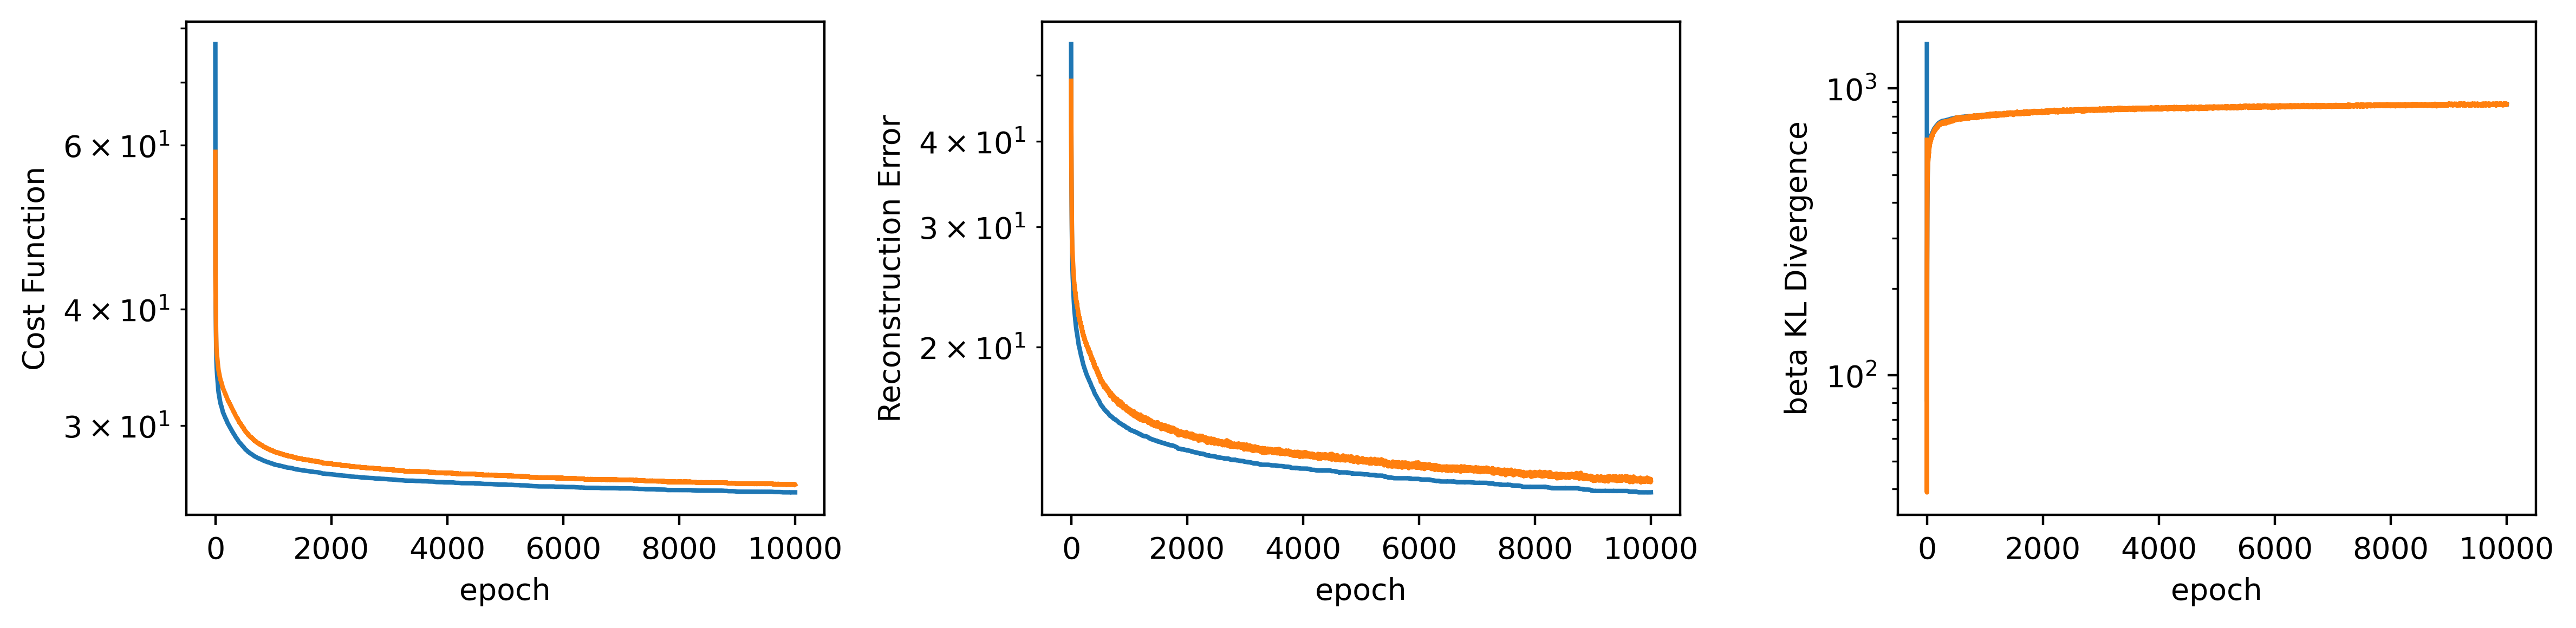

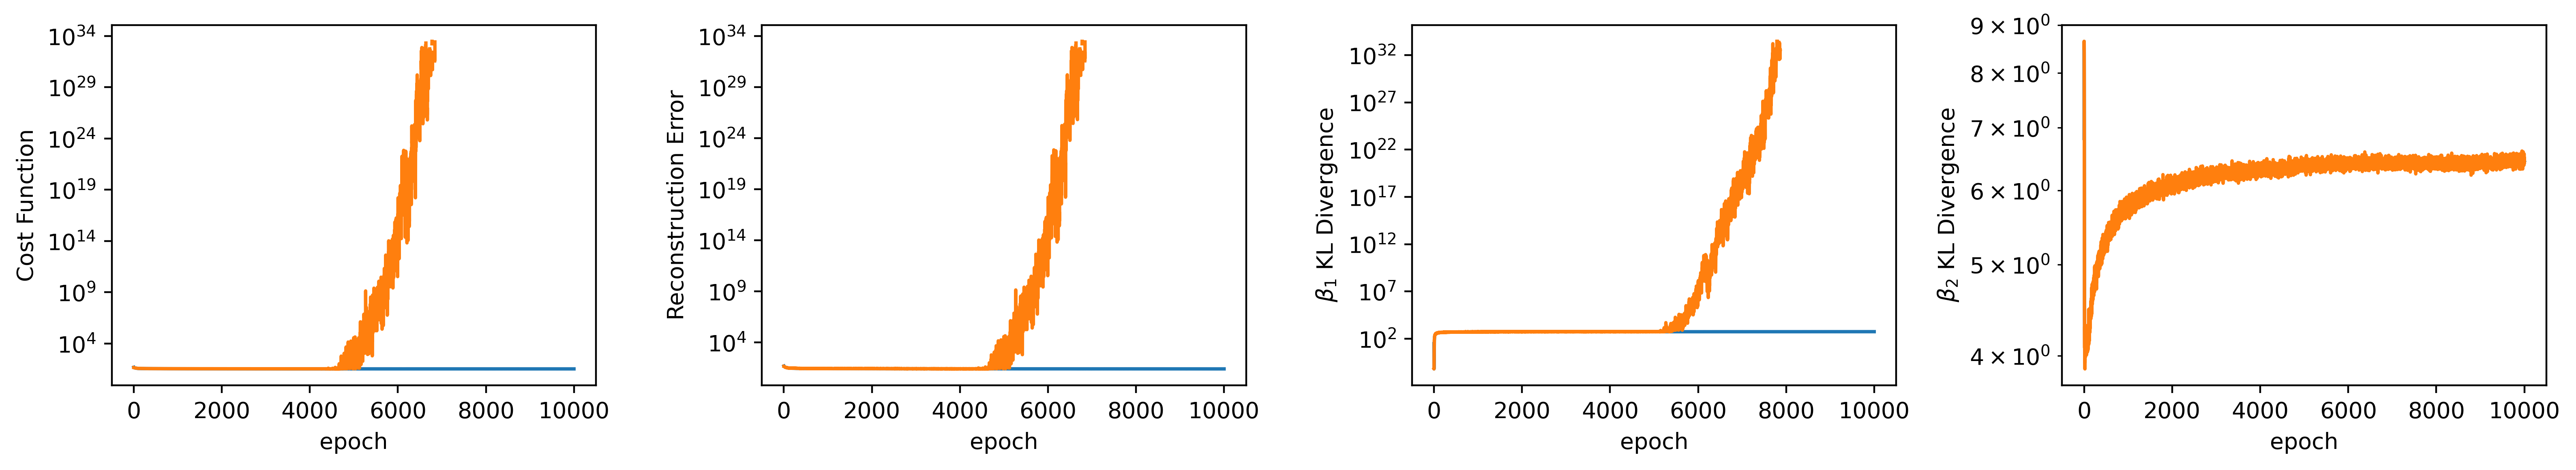

In [9]:
ylabels_eavae = ['Cost Function','Reconstruction Error',r'$\beta_1$ KL Divergence',r'$\beta_2$ KL Divergence']
ylabels_vae = ['Cost Function','Reconstruction Error','beta KL Divergence']

plot_losses(vae_losses, ylabels_vae)
plot_losses(eavae_losses, ylabels_eavae)

## If there's an instability, set the best_epoch before the instability
### Example: best_e_eavae = 4200 for the manuscript EA-VAE

In [ ]:
#If there's an instability, set the best_epoch before the instability
if use_manuscript_training:
    best_e_vae = torch.load(in_location_VAE+"bestepoch.pth")
    best_e_eavae = 4200

    state_dict_vae = torch.load(in_location_VAE+'bestnet.pth')
    state_dict_eavae = torch.load(in_location_EAVAE+f'checkpoint_epoch_{best_e_eavae}.pth')
else:
    best_e_vae = torch.load(in_location_VAE+"bestepoch.pth")
    best_e_eavae = 4200 #COMPLETE

    state_dict_vae = torch.load(in_location_VAE+'bestnet.pth')
    state_dict_eavae = torch.load(in_location_EAVAE+f'checkpoint_epoch_{best_e_eavae}.pth') #COMPLETE

## Load trained VAE and EA-VAE models

In [11]:
## loading models
# checking if torch.cuda is available
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

model_vae = Laplace_FC_VAE(512000, 128000,latent_dim_vae,imsize,learning_rate,weight_decay, device=device);
model_eavae = Gamma_free_Laplace_FC_VAE(512000, 128000,latent_dim_eavae,imsize,learning_rate,weight_decay,k_param,theta_param, device=device);

model_vae.load_state_dict(state_dict_vae);
model_eavae.load_state_dict(state_dict_eavae);

model_vae = model_vae.to(device);
model_eavae = model_eavae.to(device);

model_vae.eval();
model_eavae.eval();

## Compute natural images reconstructions (VAE & EA-VAE)

In [13]:
# checking image reconstruction
model_vae.eval()
model_eavae.eval()
x_ori = []
x_vae = []
x_eavae = []
for x, y in test_dataloader:
    with torch.no_grad():
        x_hat_eavae, _, _, _ = model_eavae(x.to(model_eavae.device), only_mu=True, only_zmu=True)
        x_hat_vae, _, _ = model_vae(x.to(model_vae.device), only_mu=True)
    k=0
    l=0
    while k<16:
        if test_mean_and_std[l,1]>0.75:

            x_ori.append(x[l].detach().cpu().numpy())
            x_vae.append(x_hat_vae[l].detach().cpu().numpy())
            x_eavae.append(x_hat_eavae[l].detach().cpu().numpy())
            
            k+=1
        l+=1
    break # just one batch

## Compute latent posteriors for natural images and uninformative image, and Latent Receptive Fields

In [21]:
model_vae.eval()
model_eavae.eval()

avimg = torch.zeros(1,40,40)
for i in range(len(test_dataset)):
    avimg += test_dataset[i][0].reshape(40,40)
avimg = avimg/len(test_dataset)

val_mu_vae, val_var_vae, val_zmu_vae, val_zvar_vae = data_posteriors(model_vae, validation_dataloader, latent_dim_vae, False)
val_mu_eavae, val_var_eavae, val_zmu_eavae, val_zvar_eavae = data_posteriors(model_eavae, validation_dataloader, latent_dim_eavae, with_z=False, with_free_z=True)

val_av_post_mu_vae, val_av_post_cov_vae = average_posterior(val_mu_vae, val_var_vae)
val_av_post_mu_eavae, val_av_post_cov_eavae = average_posterior(val_mu_eavae, val_var_eavae)

uncertain_mu_vae, uncertain_var_vae, uncertain_zmu_vae, uncertain_zvar_vae = individual_posterior(model_vae, avimg.flatten()*0, False)
uncertain_mu_eavae, uncertain_var_eavae, uncertain_zmu_eavae, uncertain_zvar_eavae = individual_posterior(model_eavae, avimg.flatten()*0, with_z=False, with_free_z=True)

F_val_vae = spike_triggered_average(model_vae, validation_dataloader, imsize, latent_dim_vae, with_z=False, X=None, Y=None)
F_val_eavae = spike_triggered_average(model_eavae, validation_dataloader, imsize, latent_dim_eavae, with_z=False, with_free_z=True, X=None, Y=None)

In [16]:
test_mu_vae, test_var_vae, test_zmu_vae, test_zvar_vae = data_posteriors(model_vae, test_dataloader, latent_dim_vae, with_z=False)
test_mu_eavae, test_var_eavae, test_zmu_eavae, test_zvar_eavae = data_posteriors(model_eavae, test_dataloader, latent_dim_eavae, with_z=False, with_free_z=True)

test_av_post_mu_vae, test_av_post_cov_vae = average_posterior(test_mu_vae, test_var_vae)
test_av_post_mu_eavae, test_av_post_cov_eavae = average_posterior(test_mu_eavae, test_var_eavae)

uncertain_mu_vae, uncertain_var_vae, uncertain_zmu_vae, uncertain_zvar_vae = individual_posterior(model_vae, avimg.flatten()*0, False)
uncertain_mu_eavae, uncertain_var_eavae, uncertain_zmu_eavae, uncertain_zvar_eavae = individual_posterior(model_eavae, avimg.flatten()*0, with_z=False, with_free_z=True)

F_test_vae = spike_triggered_average(model_vae, test_dataloader, imsize, latent_dim_vae, with_z=False, X=None, Y=None)
F_test_eavae = spike_triggered_average(model_eavae, test_dataloader, imsize, latent_dim_eavae, with_z=False, with_free_z=True, X=None, Y=None)


## Discern latent units as informative or non-informative according to their contribution to the dataset reconstruction.

In [18]:
# computation for selecting active and passive latent dimensions
if use_manuscript_training:
    val_mean_rec_sqr_diff_vae = np.load(out_location + 'val_mean_rec_sqr_diff_vae.npy')
    val_mean_rec_sqr_diff_eavae = np.load(out_location + 'val_mean_rec_sqr_diff_eavae.npy')
else: #TAKES 1-2 HOURS TO RUN
    val_mean_rec_sqr_diff_vae = latent_dim_contribution(model_vae, validation_dataloader, latent_dim_vae, with_z=False, with_free_z=False)
    val_mean_rec_sqr_diff_eavae = latent_dim_contribution(model_eavae, validation_dataloader, latent_dim_eavae, with_z=False, with_free_z=True)

    np.save(out_location + 'val_mean_rec_sqr_diff_vae.npy', val_mean_rec_sqr_diff_vae)
    np.save(out_location + 'val_mean_rec_sqr_diff_eavae.npy', val_mean_rec_sqr_diff_eavae)

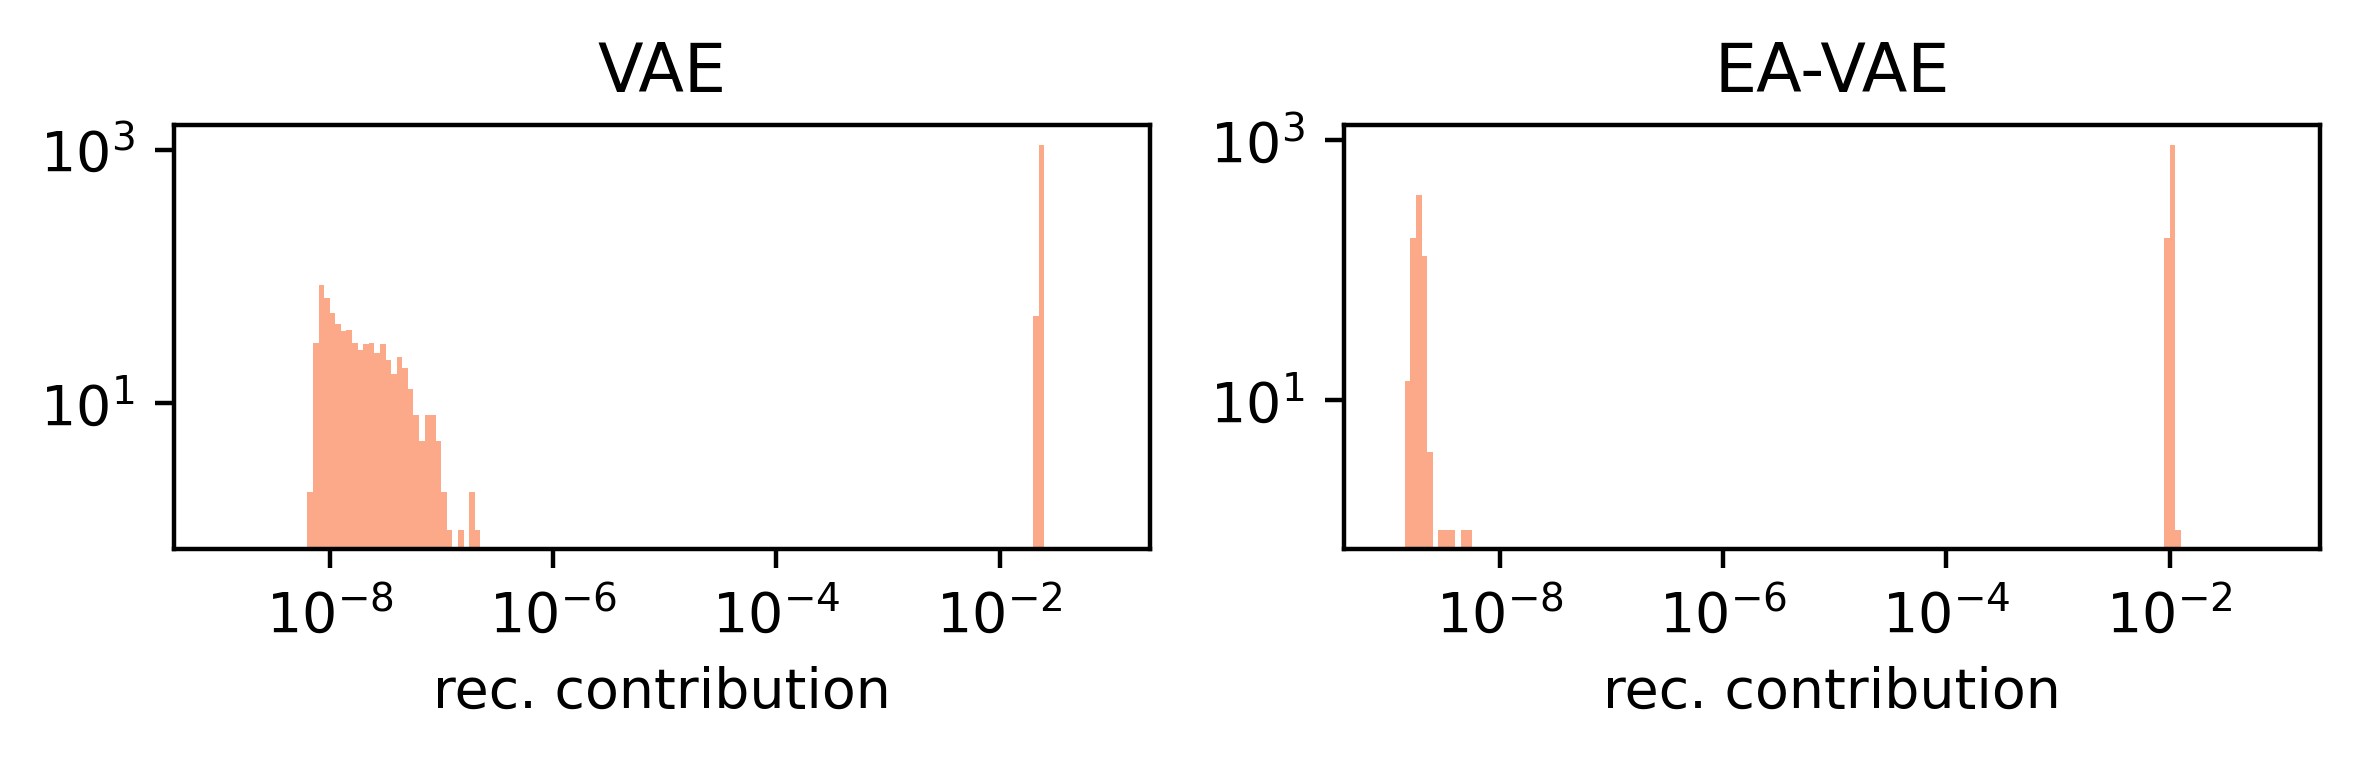

In [19]:
plt.figure(figsize = (6,2))
plt.subplot(1,2,1)
plt.title('VAE')
xx_bins = 10**(np.arange(-9,-1,.05))
plt.hist(val_mean_rec_sqr_diff_vae,bins=xx_bins,color=sns.color_palette("Set2")[1],alpha=.75)
plt.xlabel('rec. contribution')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.subplot(1,2,2)
plt.title('EA-VAE')
xx_bins = 10**(np.arange(-9,-1,.05))
plt.hist(val_mean_rec_sqr_diff_eavae,bins=xx_bins,color=sns.color_palette("Set2")[1],alpha=.75)
plt.xlabel('rec. contribution')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()

In [20]:
#Given the histograms, divide active and passive
if use_manuscript_training:
    threshold = 1.e-3
    decoration_idxs_vae = np.where(val_mean_rec_sqr_diff_vae<threshold)[0]
    informative_idxs_vae = np.where(val_mean_rec_sqr_diff_vae>threshold)[0]
    decoration_idxs_eavae = np.where(val_mean_rec_sqr_diff_eavae<threshold)[0]
    informative_idxs_eavae = np.where(val_mean_rec_sqr_diff_eavae>threshold)[0]
else:
    threshold = 1.e-3 #COMPLETE
    decoration_idxs_vae = np.where(val_mean_rec_sqr_diff_vae<threshold)[0]
    informative_idxs_vae = np.where(val_mean_rec_sqr_diff_vae>threshold)[0]
    decoration_idxs_eavae = np.where(val_mean_rec_sqr_diff_eavae<threshold)[0]
    informative_idxs_eavae = np.where(val_mean_rec_sqr_diff_eavae>threshold)[0]

## Compute signal mean, signal variance and noise variance

In [ ]:
# computing signal mean, signal variance and noise variance
binned_signal_mean_test_vae, binned_signal_var_test_vae, binned_noise_var_test_vae, binned_signal_mean_error_test_vae, binned_signal_var_error_test_vae, binned_noise_var_error_test_vae, contrast_rounds_test_vae = SignalMean_SignalVar_NoiseVar(test_mu_vae,test_var_vae,test_mean_and_std[:,1],informative_idxs_vae)
binned_signal_mean_test_eavae, binned_signal_var_test_eavae, binned_noise_var_test_eavae, binned_signal_mean_error_test_eavae, binned_signal_var_error_test_eavae, binned_noise_var_error_test_eavae, contrast_rounds_test_eavae = SignalMean_SignalVar_NoiseVar(test_mu_eavae,test_var_eavae,test_mean_and_std[:,1],informative_idxs_eavae,with_z=False, with_free_z=True)

## Save results

In [22]:
with open(out_location+'x_ori.pkl', 'wb') as f:
    pkl.dump(x_ori, f)
with open(out_location+'x_vae.pkl', 'wb') as f:
    pkl.dump(x_vae, f)
with open(out_location+'x_eavae.pkl', 'wb') as f:
    pkl.dump(x_eavae, f)

np.save(out_location+'nat_test_zmu_eavae.npy',test_zmu_eavae)
np.save(out_location+'nat_test_zvar_eavae.npy',test_zvar_eavae)
np.save(out_location+'test_mean_and_std.npy',test_mean_and_std)
np.save(out_location+'nat_train_pixs_std.npy',nat_train_pixs_std)

np.save(out_location+'F_test_eavae.npy',F_test_eavae)
np.save(out_location+'informative_idxs_eavae.npy',informative_idxs_eavae)
np.save(out_location+'decoration_idxs_eavae.npy',decoration_idxs_eavae)
np.save(out_location+'F_test_vae.npy',F_test_vae)
np.save(out_location+'informative_idxs_vae.npy',informative_idxs_vae)
np.save(out_location+'decoration_idxs_vae.npy',decoration_idxs_vae)

np.save(out_location+'binned_signal_mean_test_vae.npy',binned_signal_mean_test_vae)
np.save(out_location+'binned_signal_var_test_vae.npy',binned_signal_var_test_vae)
np.save(out_location+'binned_noise_var_test_vae.npy',binned_noise_var_test_vae)
np.save(out_location+'binned_signal_mean_error_test_vae.npy',binned_signal_mean_error_test_vae)
np.save(out_location+'binned_signal_var_error_test_vae.npy',binned_signal_var_error_test_vae)
np.save(out_location+'binned_noise_var_error_test_vae.npy',binned_noise_var_error_test_vae)
np.save(out_location+'contrast_rounds_test_vae.npy',contrast_rounds_test_vae)

np.save(out_location+'binned_signal_mean_test_eavae.npy',binned_signal_mean_test_eavae)
np.save(out_location+'binned_signal_var_test_eavae.npy',binned_signal_var_test_eavae)
np.save(out_location+'binned_noise_var_test_eavae.npy',binned_noise_var_test_eavae)
np.save(out_location+'binned_signal_mean_error_test_eavae.npy',binned_signal_mean_error_test_eavae)
np.save(out_location+'binned_signal_var_error_test_eavae.npy',binned_signal_var_error_test_eavae)
np.save(out_location+'binned_noise_var_error_test_eavae.npy',binned_noise_var_error_test_eavae)
np.save(out_location+'contrast_rounds_test_eavae.npy',contrast_rounds_test_eavae)

## Out-of-distribution experiment

### Generate necessary datasets and DataLoaders

In [45]:
img_transform_ood = transforms.Compose([
    transforms.Resize((40,40)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x:vec_transform(x)),
    transforms.Lambda(lambda x:zero_mean(x))
])
## MNIST Dataset
data_dir = f'{ROOT_PATH}/Datasets/Mnist/'

num_test_dataset = MNIST(root=data_dir+'MNIST', download=True, train=False, transform=img_transform_ood)
num_test_dataloader = DataLoader(num_test_dataset, batch_size=batch_size, shuffle=False)
num_n_test = len(num_test_dataset)

#ChestMNIST Dataset
data_flag = 'chestmnist'
download = True

BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])


med_test_dataset = DataClass(split='test', transform=img_transform_ood, download=download)
med_test_dataloader = DataLoader(dataset=med_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## FashionMNIST Dataset
data_dir = f'{ROOT_PATH}/Datasets/FashionMnist/'
fash_test_dataset = FashionMNIST(root=data_dir+'FashionMNIST', download=True, train=False, transform=img_transform_ood)
fash_test_dataloader = DataLoader(fash_test_dataset, batch_size=batch_size, shuffle=False)

rnd_pix_shuff_imgs = np.zeros((10000,40,40))
# shuffle pixels across first axis
for k in range(10000):
    rnd_pix_shuff_imgs[k] = test_dataset[k][0].reshape((40,40))
for i in range(40):
    for j in range(40):
        torch.manual_seed(40*i+j)
        rnd_pix_shuff_imgs[:,i,j] = rnd_pix_shuff_imgs[:,i,j][torch.randperm(10000)]
rnd_pix_shuff_imgs = np.expand_dims(rnd_pix_shuff_imgs,1).astype(np.float32).reshape(10000,1600)
batch_size = 128

nat_test_ShuffPix_dataset = CsikorShuffDataset(test_labels[:10000],rnd_pix_shuff_imgs)
nat_test_ShuffPix_dataloader = DataLoader(nat_test_ShuffPix_dataset, batch_size=batch_size, shuffle=False)

Using downloaded and verified file: /home/jcatoni/.medmnist/chestmnist.npz


### Compute latent posteriors for in-distribution and out-of-distribution images

In [46]:
med_test_mu_vae, med_test_var_vae, med_test_zmu_vae, med_test_zvar_vae = data_posteriors(model_vae, med_test_dataloader, latent_dim_vae, False)
med_test_mu_eavae, med_test_var_eavae, med_test_zmu_eavae, med_test_zvar_eavae = data_posteriors(model_eavae, med_test_dataloader, latent_dim_eavae, with_z=False, with_free_z=True)

num_test_mu_vae, num_test_var_vae, num_test_zmu_vae, num_test_zvar_vae = data_posteriors(model_vae, num_test_dataloader, latent_dim_vae, False)
num_test_mu_eavae, num_test_var_eavae, num_test_zmu_eavae, num_test_zvar_eavae = data_posteriors(model_eavae, num_test_dataloader, latent_dim_eavae, with_z=False, with_free_z=True)

fash_test_mu_vae, fash_test_var_vae, fash_test_zmu_vae, fash_test_zvar_vae = data_posteriors(model_vae, fash_test_dataloader, latent_dim_vae, False)
fash_test_mu_eavae, fash_test_var_eavae, fash_test_zmu_eavae, fash_test_zvar_eavae = data_posteriors(model_eavae, fash_test_dataloader, latent_dim_eavae, with_z=False, with_free_z=True)

nat_test_ShuffPix_mu_vae, nat_test_ShuffPix_var_vae, nat_test_ShuffPix_zmu_vae, nat_test_ShuffPix_zvar_vae = data_posteriors(model_vae, nat_test_ShuffPix_dataloader, latent_dim_vae, False)
nat_test_ShuffPix_mu_eavae, nat_test_ShuffPix_var_eavae, nat_test_ShuffPix_zmu_eavae, nat_test_ShuffPix_zvar_eavae = data_posteriors(model_eavae, nat_test_ShuffPix_dataloader, latent_dim_eavae, with_z=False, with_free_z=True)


In [47]:
fash_uncertainty_vae_df = pd.DataFrame({'uncertainty':np.sqrt(fash_test_var_vae[:,informative_idxs_vae]).mean(axis=1), 'model':'VAE', 'data-set':'FashionMNIST'})
med_uncertainty_vae_df = pd.DataFrame({'uncertainty':np.sqrt(med_test_var_vae[:,informative_idxs_vae]).mean(axis=1), 'model':'VAE', 'data-set':'ChestMNIST'})
num_uncertainty_vae_df = pd.DataFrame({'uncertainty':np.sqrt(num_test_var_vae[:,informative_idxs_vae]).mean(axis=1), 'model':'VAE', 'data-set':'MNIST'})
nat_uncertainty_vae_df = pd.DataFrame({'uncertainty':np.sqrt(test_var_vae[:,informative_idxs_vae]).mean(axis=1), 'model':'VAE', 'data-set':'van Hateren'})
nat_ShuffPix_uncertainty_vae_df = pd.DataFrame({'uncertainty':np.sqrt(nat_test_ShuffPix_var_vae[:,informative_idxs_vae]).mean(axis=1), 'model':'VAE', 'data-set':'van Hateren permuted pixels'})
fash_uncertainty_eavae_df = pd.DataFrame({'uncertainty':np.sqrt(fash_test_var_eavae[:,informative_idxs_eavae]).mean(axis=1), 'model':'EA-VAE', 'data-set':'FashionMNIST'})
med_uncertainty_eavae_df = pd.DataFrame({'uncertainty':np.sqrt(med_test_var_eavae[:,informative_idxs_eavae]).mean(axis=1), 'model':'EA-VAE', 'data-set':'ChestMNIST'})
num_uncertainty_eavae_df = pd.DataFrame({'uncertainty':np.sqrt(num_test_var_eavae[:,informative_idxs_eavae]).mean(axis=1), 'model':'EA-VAE', 'data-set':'MNIST'})
nat_uncertainty_eavae_df = pd.DataFrame({'uncertainty':np.sqrt(test_var_eavae[:,informative_idxs_eavae]).mean(axis=1), 'model':'EA-VAE', 'data-set':'van Hateren'})
nat_ShuffPix_uncertainty_eavae_df = pd.DataFrame({'uncertainty':np.sqrt(nat_test_ShuffPix_var_eavae[:,informative_idxs_eavae]).mean(axis=1), 'model':'EA-VAE', 'data-set':'van Hateren permuted pixels'})

fash_zmu_vae_df = pd.DataFrame({'z_mu':fash_test_zmu_vae[:,0], 'model':'VAE', 'data-set':'FashionMNIST'})
med_zmu_vae_df = pd.DataFrame({'z_mu':med_test_zmu_vae[:,0], 'model':'VAE', 'data-set':'ChestMNIST'})
num_zmu_vae_df = pd.DataFrame({'z_mu':num_test_zmu_vae[:,0], 'model':'VAE', 'data-set':'MNIST'})
nat_zmu_vae_df = pd.DataFrame({'z_mu':test_zmu_vae[:,0], 'model':'VAE', 'data-set':'van Hateren'})
fash_zmu_eavae_df = pd.DataFrame({'z_mu':fash_test_zmu_eavae[:,0], 'model':'EA-VAE', 'data-set':'FashionMNIST'})
med_zmu_eavae_df = pd.DataFrame({'z_mu':med_test_zmu_eavae[:,0] , 'model':'EA-VAE', 'data-set':'ChestMNIST'})
num_zmu_eavae_df = pd.DataFrame({'z_mu':num_test_zmu_eavae[:,0] , 'model':'EA-VAE', 'data-set':'MNIST'})
nat_zmu_eavae_df = pd.DataFrame({'z_mu':test_zmu_eavae[:,0] , 'model':'EA-VAE', 'data-set':'van Hateren'})
nat_ShuffPix_zmu_eavae_df = pd.DataFrame({'z_mu':nat_test_ShuffPix_zmu_eavae[:,0], 'model':'EA-VAE', 'data-set':'van Hateren permuted pixels'})

uncertainty_df = pd.concat([nat_uncertainty_vae_df,   nat_ShuffPix_uncertainty_vae_df,   num_uncertainty_vae_df,   fash_uncertainty_vae_df,     med_uncertainty_vae_df,
                            nat_uncertainty_eavae_df, nat_ShuffPix_uncertainty_eavae_df, num_uncertainty_eavae_df, fash_uncertainty_eavae_df,   med_uncertainty_eavae_df])

zmu_eavae_df = pd.concat([nat_zmu_eavae_df,nat_ShuffPix_zmu_eavae_df, num_zmu_eavae_df, fash_zmu_eavae_df, med_zmu_eavae_df])

uncertainty_vae_eavae_df = pd.concat([nat_uncertainty_vae_df, nat_uncertainty_eavae_df])

### Compute reconstructions for in-distribution and out-of-distribution images

In [54]:
# checking image reconstruction
model_vae.eval()
model_eavae.eval()
num_x_ori = []
num_x_vae = []
num_x_eavae = []
for x, y in num_test_dataloader:
    with torch.no_grad():
        x_hat_eavae, _, _, _ = model_eavae(x.to(model_eavae.device), only_mu=True, only_zmu=True)
        x_hat_vae, _, _ = model_vae(x.to(model_vae.device), only_mu=True)
    k=0
    l=0
    while k<16:
        if test_mean_and_std[l,1]>0.75:
            num_x_ori.append(x[l].detach().cpu().numpy())
            num_x_vae.append(x_hat_vae[l].detach().cpu().numpy())
            num_x_eavae.append(x_hat_eavae[l].detach().cpu().numpy())
            
            k+=1
        l+=1
    break # just one batch

med_x_ori = []
med_x_vae = []
med_x_eavae = []
for x, y in med_test_dataloader:
    with torch.no_grad():
        x_hat_eavae, _, _, _ = model_eavae(x.to(model_eavae.device), only_mu=True, only_zmu=True)
        x_hat_vae, _, _ = model_vae(x.to(model_vae.device), only_mu=True)
    k=0
    l=0
    while k<16:
        if test_mean_and_std[l,1]>0.75:
            
            med_x_ori.append(x[l].detach().cpu().numpy())
            med_x_vae.append(x_hat_vae[l].detach().cpu().numpy())
            med_x_eavae.append(x_hat_eavae[l].detach().cpu().numpy())
            
            k+=1
        l+=1
    break # just one batch

fash_x_ori = []
fash_x_vae = []
fash_x_eavae = []
for x, y in fash_test_dataloader:
    with torch.no_grad():
        x_hat_eavae, _, _, _ = model_eavae(x.to(model_eavae.device), only_mu=True, only_zmu=True)
        x_hat_vae, _, _ = model_vae(x.to(model_vae.device), only_mu=True)
    k=0
    l=0
    while k<16:
        if test_mean_and_std[l,1]>0.75:
            fash_x_ori.append(x[l].detach().cpu().numpy())
            fash_x_vae.append(x_hat_vae[l].detach().cpu().numpy())
            fash_x_eavae.append(x_hat_eavae[l].detach().cpu().numpy())
            k+=1
        l+=1
    break # just one batch

shuff_x_ori = []
shuff_x_vae = []
shuff_x_eavae = []
for x, y in nat_test_ShuffPix_dataloader:
    with torch.no_grad():
        x_hat_eavae, _, _, _ = model_eavae(x.to(model_eavae.device), only_mu=True, only_zmu=True)
        x_hat_vae, _, _ = model_vae(x.to(model_vae.device), only_mu=True)
    k=0
    l=0
    while k<16:
        if test_mean_and_std[l,1]>0.75:
            shuff_x_ori.append(x[l].detach().cpu().numpy())
            shuff_x_vae.append(x_hat_vae[l].detach().cpu().numpy())
            shuff_x_eavae.append(x_hat_eavae[l].detach().cpu().numpy())            
            k+=1
        l+=1
    break # just one batch

### Save results

In [55]:
uncertainty_df.to_pickle(out_location+'uncertainty_df')
zmu_eavae_df.to_pickle(out_location+'zmu_eavae_df')

with open(out_location+'fash_x_ori.pkl', 'wb') as f:
    pkl.dump(fash_x_ori, f)
with open(out_location+'fash_x_vae.pkl', 'wb') as f:
    pkl.dump(fash_x_vae, f)
with open(out_location+'fash_x_eavae.pkl', 'wb') as f:
    pkl.dump(fash_x_eavae, f)
    
with open(out_location+'num_x_ori.pkl', 'wb') as f:
    pkl.dump(num_x_ori, f)
with open(out_location+'num_x_vae.pkl', 'wb') as f:
    pkl.dump(num_x_vae, f)
with open(out_location+'num_x_eavae.pkl', 'wb') as f:
    pkl.dump(num_x_eavae, f)

with open(out_location+'shuff_x_ori.pkl', 'wb') as f:
    pkl.dump(shuff_x_ori, f)
with open(out_location+'shuff_x_vae.pkl', 'wb') as f:
    pkl.dump(shuff_x_vae, f)
with open(out_location+'shuff_x_eavae.pkl', 'wb') as f:
    pkl.dump(shuff_x_eavae, f)

with open(out_location+'med_x_ori.pkl', 'wb') as f:
    pkl.dump(med_x_ori, f)
with open(out_location+'med_x_vae.pkl', 'wb') as f:
    pkl.dump(med_x_vae, f)
with open(out_location+'med_x_eavae.pkl', 'wb') as f:
    pkl.dump(med_x_eavae, f)